<a href="https://colab.research.google.com/github/sudip234-source/PyTorch-Tutorial/blob/main/Transfer_Learning(VGG16)_Improving_The_mnist_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [57]:
torch.cuda.is_available()

True

In [58]:
torch.manual_seed(42)

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [60]:
df = pd.read_csv('/content/drive/MyDrive/Data Sets files/fashion-mnist_test.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [61]:
df.shape

(10000, 785)

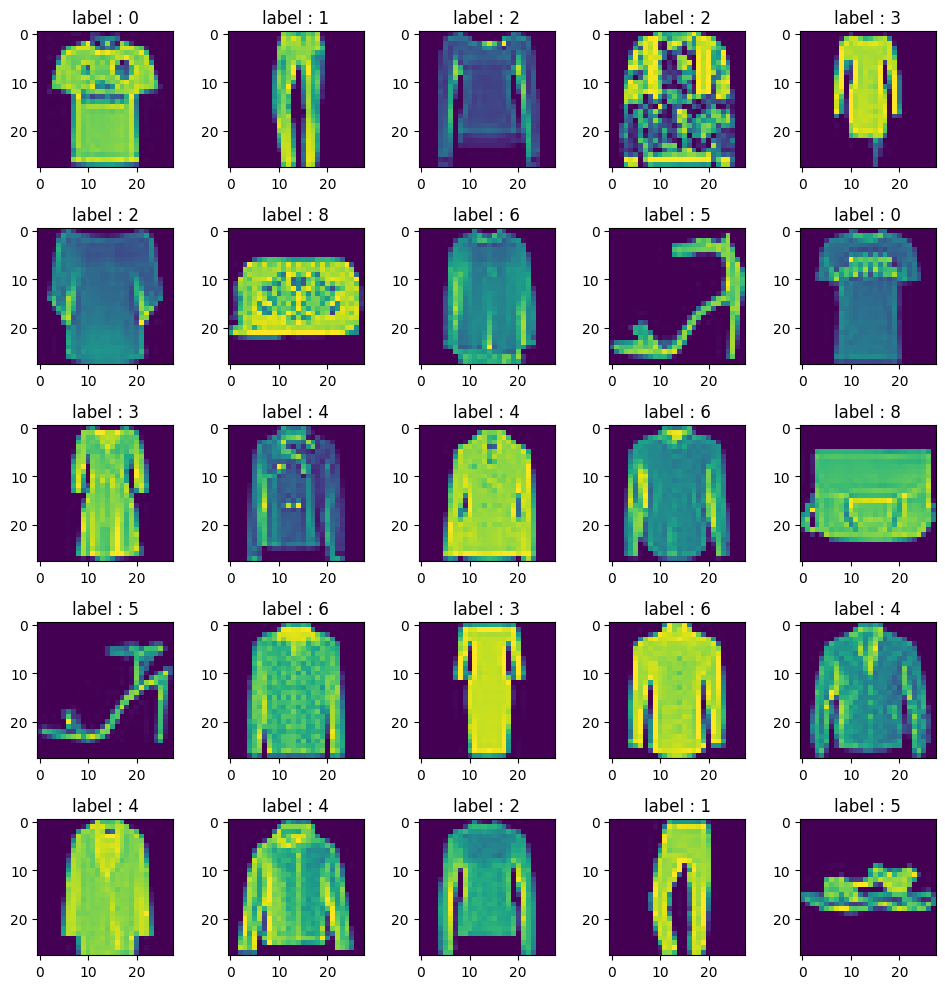

In [62]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(df.iloc[i,1:].values.reshape(28,28))
  plt.title(f"label : {df.iloc[i,0]}")
  plt.tight_layout()
plt.show()

In [63]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [65]:
X_train.shape

(8000, 784)

In [66]:
# transformation
import torchvision.transforms as transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [67]:
from PIL import Image

class myDataSet(Dataset):
  def __init__(self,X,y,transform):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    image = self.X[index].reshape(28,28)
    image = image.astype(np.uint8)
    image = np.stack([image]*3,axis=-1) # change grayscale to RGB
                                        #by (axis=-1) ==>  (C,H.W)-->(H,W,C)

    image = Image.fromarray(image)
    image = self.transform(image)

    return image,torch.tensor(self.y[index],dtype=torch.long)

In [68]:
train_dataset = myDataSet(X_train,y_train,custom_transform)
test_dataset = myDataSet(X_test,y_test,custom_transform)

In [69]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False,pin_memory=True)

In [70]:
import torchvision.models as models

model = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [72]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [73]:
for param in model.features.parameters():
  param.requires_grad = False

In [74]:
model.classifier = nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)
)

In [75]:
model = model.to(device)

In [76]:
learning_rate = 0.0001
epochs = 10

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr = learning_rate)

In [78]:
for epoch in range(epochs):
  total_epochs = 0

  for batch_features, batch_label in train_loader:
    batch_features = batch_features.to(device)
    batch_label = batch_label.to(device)
    outputs = model(batch_features)

    loss = criterion(outputs,batch_label)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    total_epoch_loss = total_epochs + loss.item()
  avg_loss = total_epoch_loss / len(train_loader)
  print(f"epoch : {epoch+1} , loss : {avg_loss}")


epoch : 1 , loss : 0.00365887713432312
epoch : 2 , loss : 0.002661134719848633
epoch : 3 , loss : 0.0014697891473770142
epoch : 4 , loss : 0.0006282290816307068
epoch : 5 , loss : 0.0007972314953804017
epoch : 6 , loss : 0.0006575756669044495
epoch : 7 , loss : 0.00043479356169700623
epoch : 8 , loss : 0.00019005049765110016
epoch : 9 , loss : 0.00048492917418479917
epoch : 10 , loss : 0.00015636730194091796


In [80]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_label in test_loader:
    batch_features = batch_features.to(device)
    batch_label = batch_label.to(device)
    outputs = model(batch_features)

    _,predicted = torch.max(outputs,1)
    total = total + batch_label.size(0)
    correct = correct + (predicted == batch_label).sum().item()

print(f"test accuracy : {100*correct/total}")

test accuracy : 90.15


In [81]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_label in train_loader:
    batch_features = batch_features.to(device)
    batch_label = batch_label.to(device)
    outputs = model(batch_features)

    _,predicted = torch.max(outputs,1)
    total = total + batch_label.size(0)
    correct = correct + (predicted == batch_label).sum().item()

print(f"training accuracy : {100*correct/total}")

training accuracy : 99.7375
